# CoViD 19 - Data Viz Lombardia

In [237]:
import os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import statsmodels.api as sm

Read data

In [169]:
file_input = []
for f in os.listdir('dati-regioni/'):
    if re.match('dpc-covid19-ita-regioni-2020',f):
        file_input.append(f)


In [170]:
df = pd.read_csv(os.path.join('dati-regioni',file_input[0]))
for i in range(1,len(file_input)):
    df = pd.concat([df, pd.read_csv(os.path.join('dati-regioni',file_input[i]))])

In [171]:
df['data'] = df.data.apply(lambda x : x[:10])
df['data'] = pd.to_datetime(df.data)
df = df.sort_values('data')
df['wday'] = df.data.dt.weekday

Quick overview of Regioni dataset:

In [193]:
print(df.shape)
df.head(6)

(798, 20)


,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,note_it,note_en,wday
12,2020-02-24,ITA,1,Piemonte,45.073274,7.680687,2,0,2,1,3,0,3,0,0,3,141,NaN,NaN,0
19,2020-02-24,ITA,2,Valle d'Aosta,45.737503,7.320149,0,0,0,0,0,0,0,0,0,0,7,NaN,NaN,0
18,2020-02-24,ITA,10,Umbria,43.106758,12.388247,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0
17,2020-02-24,ITA,4,P.A. Trento,46.068935,11.121231,0,0,0,0,0,0,0,0,0,0,3,NaN,NaN,0
16,2020-02-24,ITA,9,Toscana,43.769231,11.255889,0,0,0,0,0,0,0,0,0,0,140,NaN,NaN,0
15,2020-02-24,ITA,19,Sicilia,38.115697,13.362357,0,0,0,0,0,0,0,0,0,0,5,NaN,NaN,0


In [173]:
df_lom = df[df.denominazione_regione.isin(['Lombardia'])]

## Plots

### (1) - Nuovi casi di contagi giornalieri in Lombardia.

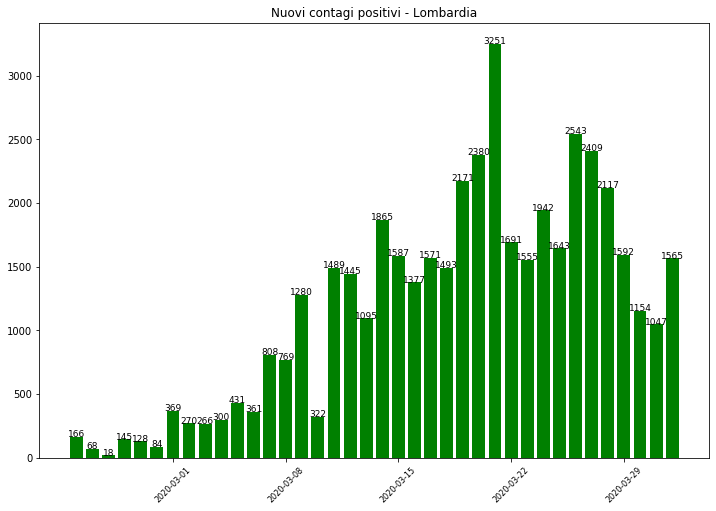

In [194]:
plt.rcParams['figure.figsize'] = 12, 8
p=plt.bar(x=df_lom.data, height=df_lom.nuovi_positivi,color='green')
for l in range(len(df_lom.nuovi_positivi)):
    plt.text(x=df_lom.data.values[l],
             y=df_lom.nuovi_positivi.values[l],
             s=df_lom.nuovi_positivi.values[l],fontsize=9,horizontalalignment='center')
_ = plt.title('Nuovi contagi positivi - Lombardia')
_=plt.xticks(df_lom[df_lom.wday.isin([6])].data.values,rotation = 45,size=8)

### (2) Nuovi contagi confrontati con il resto d'Italia

In [180]:
gdf = df.groupby(['data']).agg({'nuovi_positivi':'sum'}).reset_index().rename(columns={'nuovi_positivi':'nuovi_positivi_ita'})
df_lom = pd.merge(df_lom, gdf, on=['data'])

In [181]:
df_lom['perc_nuovi_positivi'] = df_lom.nuovi_positivi / df_lom.nuovi_positivi_ita

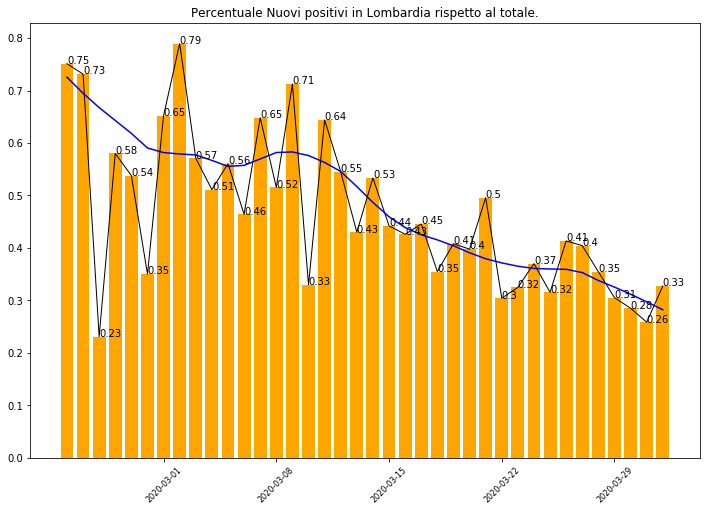

In [254]:
plt.rcParams['figure.figsize'] = 12, 8
smooth = sm.nonparametric.lowess(exog=list(np.arange(len(df_lom))), endog=df_lom.perc_nuovi_positivi.values,frac=0.3)[:,1]
plt.plot(df_lom.data, df_lom.perc_nuovi_positivi,color='black',linewidth=1)
plt.bar(x=df_lom.data, height=df_lom.perc_nuovi_positivi,color='orange')
plt.plot(df_lom.data, smooth,color='blue')
_ = plt.xticks(df_lom[df_lom.wday.isin([6])].data.values,rotation = 45,size=8)
for l in range(len(df_lom.perc_nuovi_positivi)):
    plt.text(x=df_lom.data.values[l],
             y=df_lom.perc_nuovi_positivi.values[l],
             s=round(df_lom.perc_nuovi_positivi.values[l],2))
_ = plt.title('Percentuale Nuovi positivi in Lombardia rispetto al totale.')



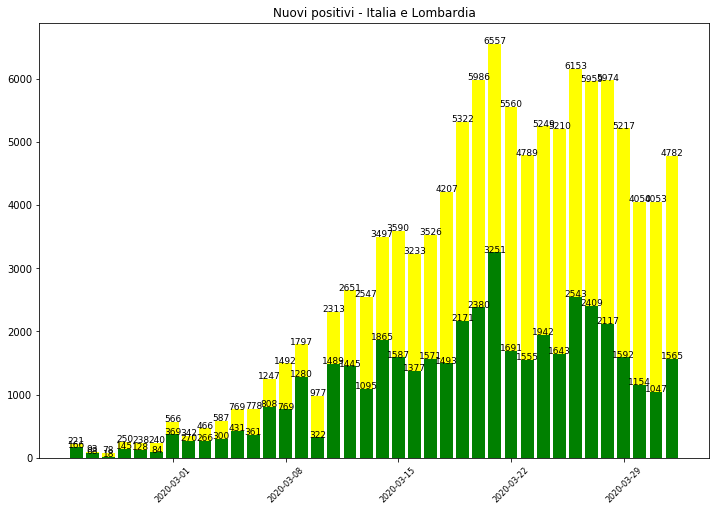

In [199]:
plt.rcParams['figure.figsize'] = 12, 8
plt.bar(x=df_lom.data, height=df_lom.nuovi_positivi_ita,color='yellow')
_ = plt.xticks(rotation = 45,size=8)
for l in range(len(df_lom.perc_nuovi_positivi)):
    plt.text(x=df_lom.data.values[l],
             y=df_lom.nuovi_positivi_ita.values[l],
             s=round(df_lom.nuovi_positivi_ita.values[l],2),fontsize=9,horizontalalignment='center')
plt.bar(x=df_lom.data, height=df_lom.nuovi_positivi,color='green')
_ = plt.xticks(df_lom[df_lom.wday.isin([6])].data.values,rotation = 45,size=8)
for l in range(len(df_lom.nuovi_positivi)):
    plt.text(x=df_lom.data.values[l],
             y=df_lom.nuovi_positivi.values[l],
             s=df_lom.nuovi_positivi.values[l],fontsize=9,horizontalalignment='center')
_ = plt.title('Nuovi positivi - Italia e Lombardia')

In [185]:
i = len(df_lom)-1
print("Change Percentage Lombardia: {}".format(np.round(df_lom.nuovi_positivi.pct_change()[i],2)))
print("Change Percentage Italia: {}".format(np.round(df_lom.nuovi_positivi_ita.pct_change()[i],2)))

Change Percentage Lombardia: 0.49
Change Percentage Italia: 0.18


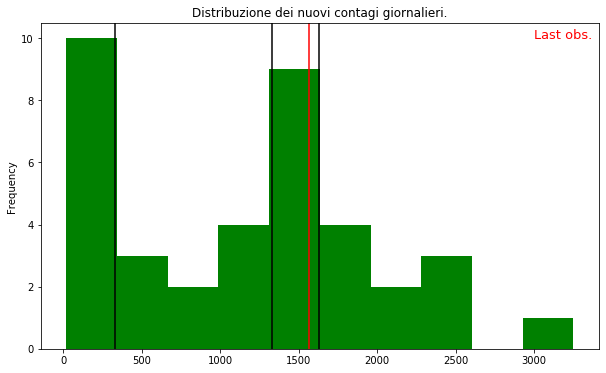

In [200]:
plt.rcParams['figure.figsize'] = 10, 6
median_lom = np.quantile(df_lom.nuovi_positivi,q=[0.5])
df_lom.nuovi_positivi.plot.hist(color='green')#bins=20)
plt.axvline(median_lom,color='black')
plt.axvline(np.quantile(df_lom.nuovi_positivi,q=[0.25]),color='black')
plt.axvline(np.quantile(df_lom.nuovi_positivi,q=[0.75]),color='black')
plt.axvline(df_lom.nuovi_positivi[i],color='red')
_ = plt.text(x=3000, y=10,s='Last obs.',color='red',fontsize=13)
_=plt.title("Distribuzione dei nuovi contagi giornalieri.")

In [202]:
from scipy import stats
pctl_last_obs = np.round(stats.percentileofscore(df_lom.nuovi_positivi,df_lom.nuovi_positivi[i]),2)
print("L'ultima osservazione si trova al {}-mo percentile.".format(pctl_last_obs))

L'ultima osservazione si trova al 65.79-mo percentile.


### (3) Percentage change plot

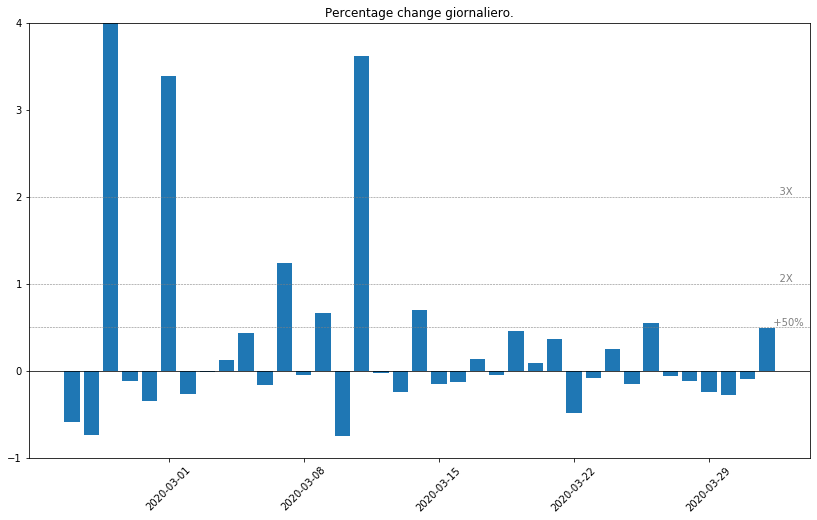

In [223]:
plt.rcParams['figure.figsize'] = 14, 8
plt.bar(
    x=df_lom.data,
    height=df_lom.nuovi_positivi.pct_change(periods=1)
)
_=plt.xticks(df_lom[df_lom.wday.isin([6])].data.values,rotation=45)
plt.ylim(-1,4)
_=plt.axhline(0,color='black',linestyle='-',linewidth=0.75)
_=plt.axhline(0.5,color='gray',linestyle='--',linewidth=0.55)
_=plt.axhline(1,color='gray',linestyle='--',linewidth=0.55)
_=plt.axhline(2,color='gray',linestyle='--',linewidth=0.55)
_=plt.text(x=df_lom.data[i],y=0.52,s="  +50%",color='gray')
_=plt.text(x=df_lom.data[i],y=1.02,s="    2X",color='gray')
_=plt.text(x=df_lom.data[i],y=2.02,s="    3X",color='gray')
_=plt.title("Percentage change giornaliero.")



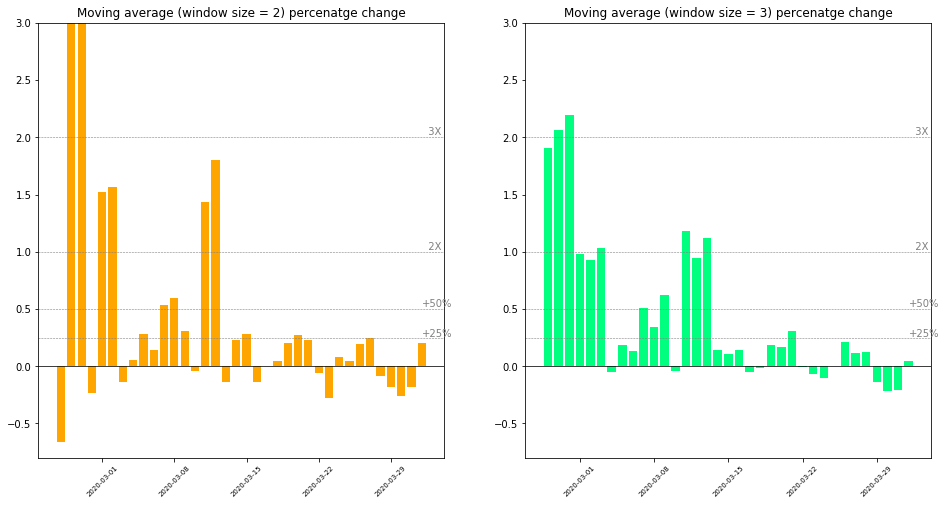

In [233]:
plt.rcParams['figure.figsize'] = 16, 8

plt.subplot(121)
plt.bar(
    x=df_lom.data,
    height=df_lom.nuovi_positivi.pct_change(1).rolling(2).sum()/2,
    color='orange'
)
_=plt.xticks(df_lom[df_lom.wday.isin([6])].data.values,rotation=45,size=7)
plt.ylim(-0.8,3)
_=plt.axhline(0,color='black',linestyle='-',linewidth=0.75)
_=plt.axhline(0.25,color='gray',linestyle='--',linewidth=0.55)
_=plt.axhline(0.5,color='gray',linestyle='--',linewidth=0.55)
_=plt.axhline(1,color='gray',linestyle='--',linewidth=0.55)
_=plt.axhline(2,color='gray',linestyle='--',linewidth=0.55)
_=plt.text(x=df_lom.data[i],y=0.26,s="+25%",color='gray')
_=plt.text(x=df_lom.data[i],y=0.52,s="+50%",color='gray')
_=plt.text(x=df_lom.data[i],y=1.02,s="  2X",color='gray')
_=plt.text(x=df_lom.data[i],y=2.02,s="  3X",color='gray')
_=plt.title('Moving average (window size = 2) percenatge change')

plt.subplot(122)
plt.bar(
    x=df_lom.data,
    height=df_lom.nuovi_positivi.pct_change(1).rolling(3).sum()/3,
    color='springgreen'
)
_=plt.xticks(df_lom[df_lom.wday.isin([6])].data.values,rotation=45,size=7)
plt.ylim(-0.8,3)
_=plt.axhline(0,color='black',linestyle='-',linewidth=0.75)
_=plt.axhline(0.25,color='gray',linestyle='--',linewidth=0.55)
_=plt.axhline(0.5,color='gray',linestyle='--',linewidth=0.55)
_=plt.axhline(1,color='gray',linestyle='--',linewidth=0.55)
_=plt.axhline(2,color='gray',linestyle='--',linewidth=0.55)
_=plt.text(x=df_lom.data[i],y=0.26,s="+25%",color='gray')
_=plt.text(x=df_lom.data[i],y=0.52,s="+50%",color='gray')
_=plt.text(x=df_lom.data[i],y=1.02,s="  2X",color='gray')
_=plt.text(x=df_lom.data[i],y=2.02,s="  3X",color='gray')
_=plt.title('Moving average (window size = 3) percenatge change')
